Обработка в PySpark

In [ ]:
import socket
# проверка доступности namenode
socket.gethostbyname("namenode")

'172.18.0.2'

In [142]:
pip show pyspark

Name: pyspark
Version: 3.5.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/spark/python
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [143]:
!python --version
!java -version

Python 3.11.6
openjdk version "17.0.8.1" 2023-08-24
OpenJDK Runtime Environment (build 17.0.8.1+1-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 17.0.8.1+1-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [ ]:
!pip install pandas

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

# Создание SparkSession с настройками для HDFS
spark = SparkSession.builder \
    .appName("COVID-19 Data Processing") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true") \
    .config("spark.hadoop.dfs.replication", "1") \
    .getOrCreate()

try:
    # Загрузка данных с проверкой
    hdfs_path = "hdfs://namenode:9000/tmp/covid_dataset/metadata/metadata.parquet"
    df = spark.read.parquet(hdfs_path)
    
    print(f"Всего записей в датасете: {df.count()}")
    
    # Фильтрация COVID-19 пациентов
    covid_patients = df.filter(col("finding").contains("COVID-19"))
    covid_count = covid_patients.count()
    
    if covid_count > 0:
        print(f"\nНайдено {covid_count} пациентов с COVID-19")
        print("\nПервые 5 записей:")
        
        # Красивый вывод через Pandas
        display(covid_patients.limit(5).toPandas())
        
        # Сохранение результатов
        output_path = "hdfs://namenode:9000/tmp/covid_dataset/processed/covid_patients.parquet"
        try:
            covid_patients.write.mode("overwrite").parquet(output_path)
            print(f"\nДанные успешно сохранены в {output_path}")
        except Exception as e:
            print(f"\nОшибка при сохранении: {str(e)}")
    else:
        print("Пациентов с COVID-19 не найдено")
        
except Exception as e:
    print(f"Ошибка при обработке данных: {str(e)}")
    
finally:
    spark.stop()
    print("\nSpark сессия закрыта")

In [108]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import StringType
import pandas as pd
from IPython.display import display

# Создание SparkSession с настройками для HDFS
spark = SparkSession.builder \
    .appName("COVID-19 Data Processing") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true") \
    .config("spark.hadoop.dfs.replication", "1") \
    .getOrCreate()

try:
    # Загрузка данных с проверкой
    hdfs_path = "hdfs://namenode:9000/tmp/covid_dataset/metadata/metadata.parquet"
    df = spark.read.parquet(hdfs_path)
    
    print(f"Всего записей в датасете: {df.count()}")
    
   
    # 1. Унификация диагнозов через UDF
        
    # Функция для категоризации диагнозов
    def categorize_diagnosis(finding):
        if "Normal" in finding:
            return "normal"
        if "COVID-19" in finding:
            return "covid"
        elif any(disease in finding for disease in ["Pneumonia", "Tuberculosis", "Todo", "Unknown"]):
            return "other_lung_diseases"
        else:
            return "normal"
    
    # Регистрация UDF
    categorize_diagnosis_udf = udf(categorize_diagnosis, StringType())
    
    # Применение UDF
    df = df.withColumn("diagnosis_category", categorize_diagnosis_udf(col("finding")))
    
  
    # 2. Категоризация возраста
    
    
    df = df.withColumn("age_category",
                      when(col("age") < 30, "young")
                      .when((col("age") >= 30) & (col("age") < 60), "middle")
                      .otherwise("old"))
    
    
    # 3. Фильтрация и сохранение результатов
  
    
    # Фильтрация COVID-19 пациентов
    covid_patients = df.filter(col("diagnosis_category") == "covid")
    covid_count = covid_patients.count()
    
    if covid_count > 0:
        print(f"\nНайдено {covid_count} пациентов с COVID-19")
        print("\nПервые 5 записей с новыми категориями:")
        
        # Вывод с новыми колонками
        display(covid_patients.select("patientid", "age", "age_category", "finding", "diagnosis_category").limit(5).toPandas())
        
        # Сохранение результатов
        output_path = "hdfs://namenode:9000/tmp/covid_dataset/processed/processed_patients.parquet"
        try:
            df.write.mode("overwrite").parquet(output_path)
            print(f"\nВсе данные с категориями успешно сохранены в {output_path}")
            
            # Дополнительно сохраняем только COVID-19 пациентов
            covid_output_path = "hdfs://namenode:9000/tmp/covid_dataset/processed/covid_patients.parquet"
            covid_patients.write.mode("overwrite").parquet(covid_output_path)
            print(f"Данные по COVID-19 пациентам сохранены в {covid_output_path}")
            
        except Exception as e:
            print(f"\nОшибка при сохранении: {str(e)}")
    else:
        print("Пациентов с COVID-19 не найдено")
        
   
    # 4. Анализ распределения данных
    
    
    print("\nРаспределение по категориям диагнозов:")
    diagnosis_dist = df.groupBy("diagnosis_category").count().toPandas()
    display(diagnosis_dist)
    
    print("\nРаспределение по возрастным категориям:")
    age_dist = df.groupBy("age_category").count().toPandas()
    display(age_dist)
    
except Exception as e:
    print(f"Ошибка при обработке данных: {str(e)}")
    
finally:
    pass
    

Всего записей в датасете: 929

Найдено 563 пациентов с COVID-19

Первые 5 записей с новыми категориями:


,patientid,age,age_category,finding,diagnosis_category
0,2,65.0,old,COVID-19,covid
1,2,65.0,old,COVID-19,covid
2,2,65.0,old,COVID-19,covid
3,2,65.0,old,COVID-19,covid
4,4,52.0,middle,COVID-19,covid



Все данные с категориями успешно сохранены в hdfs://namenode:9000/tmp/covid_dataset/processed/processed_patients.parquet
Данные по COVID-19 пациентам сохранены в hdfs://namenode:9000/tmp/covid_dataset/processed/covid_patients.parquet

Распределение по категориям диагнозов:


,diagnosis_category,count
0,normal,22
1,covid,563
2,other_lung_diseases,344



Распределение по возрастным категориям:


,age_category,count
0,old,364
1,young,106
2,middle,459



Центры кластеров:
Кластер 0: Возраст=30.9, Пол(индекс)=0.4
Кластер 1: Возраст=51.8, Пол(индекс)=0.3
Кластер 2: Возраст=72.0, Пол(индекс)=0.4


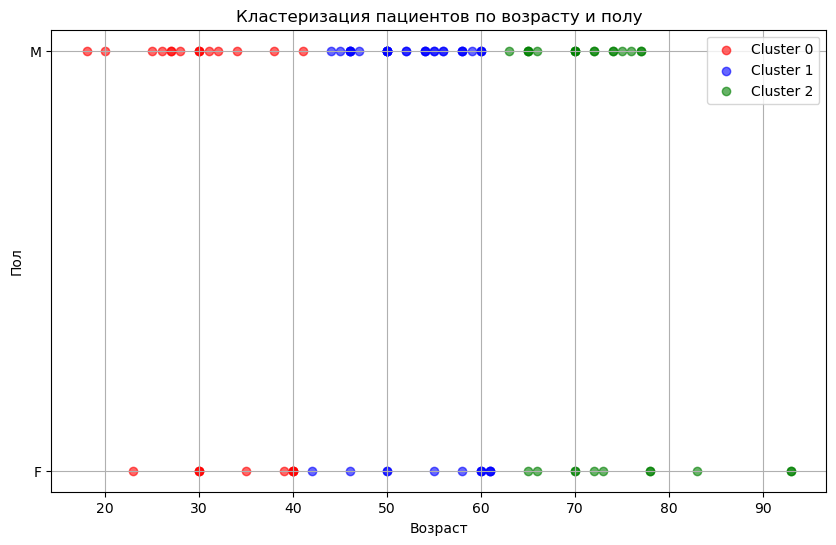


Характеристики кластеров:


,prediction,count(sex),avg(age),mode(diagnosis_category)
0,0,263,30.901141,covid
1,1,358,51.824022,covid
2,2,308,71.990260,covid



Распределения диагнозов по кластерам:
+-----------------------------+-----+------+-------------------+
|prediction_diagnosis_category|covid|normal|other_lung_diseases|
+-----------------------------+-----+------+-------------------+
|                            0|  131|     6|                126|
|                            1|  208|     8|                142|
|                            2|  224|     8|                 76|
+-----------------------------+-----+------+-------------------+


Результаты кластеризации сохранены в hdfs://namenode:9000/tmp/covid_dataset/processed/clustered_patients.parquet


In [109]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Продолжаем работу с существующей Spark сессией
try:
    
    # 1. Подготовка данных для ML
   
    # Индексируем категориальные признаки (пол)
    gender_indexer = StringIndexer(inputCol="sex", outputCol="sex_index")
    
    # Создаем вектор признаков (возраст и пол)
    assembler = VectorAssembler(
        inputCols=["age", "sex_index"],
        outputCol="features")
    
    
    # 2. Создание и обучение модели K-means
    
    
    # Инициализация K-means с 3 кластерами
    kmeans = KMeans().setK(3).setSeed(42)
    
    # Создаем pipeline
    pipeline = Pipeline(stages=[gender_indexer, assembler, kmeans])
    
    # Обучаем модель
    model = pipeline.fit(df)
    
    # Применяем модель к данным
    clustered_df = model.transform(df)
    
   
    # 3. Анализ результатов кластеризации
    
    
    # Получаем центры кластеров
    kmeans_model = model.stages[2]
    centers = kmeans_model.clusterCenters()
    
    print("\nЦентры кластеров:")
    for i, center in enumerate(centers):
        print(f"Кластер {i}: Возраст={center[0]:.1f}, Пол(индекс)={center[1]:.1f}")
    
    # Преобразуем в Pandas для визуализации
    cluster_sample = clustered_df.select("age", "sex", "prediction").sample(0.1).toPandas()
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green']
    
    for i in range(3):
        cluster_data = cluster_sample[cluster_sample['prediction'] == i]
        plt.scatter(cluster_data['age'], 
                   cluster_data['sex'],
                   c=colors[i],
                   label=f'Cluster {i}',
                   alpha=0.6)
    
    plt.title('Кластеризация пациентов по возрасту и полу')
    plt.xlabel('Возраст')
    plt.ylabel('Пол')
    plt.legend()
    plt.grid(True)
    plt.show()
        
    # 4. Интерпретация кластеров
        
    print("\nХарактеристики кластеров:")
    cluster_stats = clustered_df.groupBy("prediction").agg(
        {"age": "avg", 
         "sex": "count",
         "diagnosis_category": "mode"}
    ).orderBy("prediction").toPandas()
    
    display(cluster_stats)

    print("\nРаспределения диагнозов по кластерам:")
    clustered_df.crosstab("prediction", "diagnosis_category").show()
    
    # 5. Сохранение результатов
    
    
    ml_output_path = "hdfs://namenode:9000/tmp/covid_dataset/processed/clustered_patients.parquet"
    try:
        clustered_df.write.mode("overwrite").parquet(ml_output_path)
        print(f"\nРезультаты кластеризации сохранены в {ml_output_path}")
    except Exception as e:
        print(f"\nОшибка при сохранении результатов кластеризации: {str(e)}")
    
except Exception as e:
    print(f"Ошибка при выполнении ML анализа: {str(e)}")
    
finally:
    pass


1. Интерпретация кластеров по возрасту:
Кластер 0: Молодая группа (средний возраст ~31 год)
Кластер 1: Средняя возрастная группа (средний возраст ~52 года)
Кластер 2: Пожилая группа (средний возраст ~72 года)

2. Интерпретация по полу (индексирование):
Пол был закодирован как:
0 = мужской (условно)
1 = женский (условно)

Значения центров кластеров по полу:
~0.3-0.4 означает смешанный состав с небольшим преобладанием одного пола
Значение ближе к 0 → больше мужчин
Значение ближе к 1 → больше женщин
Все кластеры имеют примерный гендерный баланс (значения около 0.3-0.4)
Небольшое преобладание мужчин (поскольку значения <0.5)

3. Распределение диагнозов:
Во всех кластерах модальный диагноз - covid, что означает:

COVID-19 был самым частым диагнозом во всех возрастных группах
Нет существенной возрастной зависимости в распространении COVID-19 по этим данным

4. Размеры кластеров:
Кластер 1 (средняя возрастная группа) самый многочисленный (358 пациентов)
Кластеры 0 и 2 примерно равны по размеру (~260-300 пациентов)

1. Распределение COVID-19 случаев:
Кластер 2 (пожилые) имеет наибольшее абсолютное число COVID-19 случаев (224)

Однако если смотреть относительное распределение:
Кластер 0: 131/(131+6+126) ≈ 50%
Кластер 1: 208/(208+8+142) ≈ 58%
Кластер 2: 224/(224+8+76) ≈ 73%

Вывод: С возрастом вероятность COVID-19 диагноза увеличивается (от 50% у молодых до 73% у пожилых).

2. Другие легочные заболевания:
Кластер 0 (молодые): 126 случаев (48% от кластера)
Кластер 1 (средний возраст): 142 случая (40%)
Кластер 2 (пожилые): 76 случаев (25%)

Вывод: Молодые пациенты чаще имеют другие легочные заболевания, чем COVID-19.

3. Нормальные случаи:
Во всех кластерах мало случаев с нормальным диагнозом (6-8 случаев), что ожидаемо для медицинских данных.

4. Ключевые закономерности:
Возрастной градиент:

С увеличением возраста:

Доля COVID-19 ↗ (50% → 58% → 73%)
Другие легочные заболевания ↘ (48% → 40% → 25%)

Группы риска:

Молодые пациенты:
Высокий процент других легочных заболеваний
Возможно, менее уязвимы к COVID-19

Пожилые пациенты:
Явное доминирование COVID-19
Меньше других легочных патологий (возможно, COVID-19 вытесняет другие диагнозы)

In [115]:
from pyspark.sql import SparkSession

# Создаем Spark сессию
spark = SparkSession.builder \
    .appName("OptimizedDataStorage") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

# Вариант 1: Только партиционирование (рекомендуется для аналитики по возрастам)
optimized_path = "hdfs://namenode:9000/tmp/covid_dataset/processed"
clustered_df.write \
    .mode("overwrite") \
    .partitionBy("age_category") \
    .parquet(optimized_path + "_partitioned")

# Вариант 2: Только бакетирование (если нужно ускорить JOIN по полу)
clustered_df.write \
    .mode("overwrite") \
    .bucketBy(4, "sex") \
    .saveAsTable("covid_bucketed")  # Сохраняем как Hive-таблицу

# Вариант 3: Альтернатива - предварительная сортировка
(clustered_df.sortWithinPartitions("age")
    .write
    .mode("overwrite")
    .partitionBy("age_category")
    .parquet(optimized_path + "_sorted"))

In [116]:
# Проверяем сохраненные данные
print("\n Пример данных с партиционированием по возрасту:")
display(spark.read.parquet(optimized_path + "_partitioned")
       .limit(5)
       .select("patientid", "age", "age_category", "sex", "finding", "diagnosis_category")
       .toPandas()
       .style.set_caption("Первые 5 записей (партиционированные данные)")
       .background_gradient(subset=["age"], cmap='YlOrRd'))

# Проверяем бакетированную таблицу с форматированием
print("\n Пример данных с бакетированием по полу:")
bucketed_sample = spark.sql("""
    SELECT patientid, age, sex, diagnosis_category, finding 
    FROM covid_bucketed 
    LIMIT 5
""").toPandas()

display(bucketed_sample.style
       .set_caption("Первые 5 записей (бакетированные данные)")
       .set_properties(**{'text-align': 'left'})
       .bar(subset=['age'], color='#d65f5f'))


 Пример данных с партиционированием по возрасту:


,patientid,age,age_category,sex,finding,diagnosis_category
0,4,52.000000,middle,F,COVID-19,covid
1,4,52.000000,middle,F,COVID-19,covid
2,5,58.000000,middle,M,Pneumonia,other_lung_diseases
3,6,48.000000,middle,M,COVID-19,covid
4,8,42.000000,middle,F,Pneumonia,other_lung_diseases



 Пример данных с бакетированием по полу:


,patientid,age,sex,diagnosis_category,finding
0,2,65.000000,M,covid,COVID-19
1,2,65.000000,M,covid,COVID-19
2,2,65.000000,M,covid,COVID-19
3,2,65.000000,M,covid,COVID-19
4,4,52.000000,F,covid,COVID-19


SQL-аналитика

In [137]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import StringType
import pandas as pd
from IPython.display import display

# Инициализация Spark
spark = SparkSession.builder \
    .appName("COVID-19 Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true") \
    .config("spark.hadoop.dfs.replication", "1") \
    .getOrCreate()

# Проверяем доступные данные
try:
    # Путь к данным
    hdfs_path = "hdfs://namenode:9000/tmp/covid_dataset/metadata/metadata.parquet"
    
    
    # Чтение данных
    df = spark.read.parquet(hdfs_path)
    print(f"Успешно загружено {df.count()} записей")
    
    # Создаем временное представление
    df.createOrReplaceTempView("covid_data")
    
    # SQL-запрос с оконными функциями
    query = """
    SELECT 
        age_category,
        diagnosis_category,
        COUNT(*) as patient_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as total_percentage,
        RANK() OVER (ORDER BY COUNT(*) DESC) as rank
    FROM (
        SELECT 
            CASE
                WHEN age < 30 THEN 'young'
                WHEN age BETWEEN 30 AND 59 THEN 'middle'
                ELSE 'old'
            END as age_category,
            CASE
                WHEN finding LIKE '%COVID%' THEN 'covid'
                WHEN finding IN ('Pneumonia', 'Tuberculosis', 'Todo', 'Unknown') THEN 'other_lung'
                ELSE 'normal'
            END as diagnosis_category
        FROM covid_data
    )
    GROUP BY age_category, diagnosis_category
    ORDER BY age_category, patient_count DESC
    """
    
    # Выполнение запроса
    result = spark.sql(query)
    
    # Красивый вывод
    pdf = result.toPandas()
    display(pdf.style
           .set_caption("Распределение диагнозов по возрастным группам")
           .format({'total_percentage': '{:.2f}%'})
           .background_gradient(subset=['patient_count'], cmap='Blues'))
    
except Exception as e:
    print(f"Ошибка: {str(e)}")
        
finally:
    spark.stop()

Успешно загружено 929 записей


,age_category,diagnosis_category,patient_count,total_percentage,rank
0,middle,covid,258,27.77%,1
1,middle,other_lung,192,20.67%,3
2,middle,normal,9,0.97%,8
3,old,covid,250,26.91%,2
4,old,other_lung,104,11.19%,4
5,old,normal,10,1.08%,7
6,young,covid,55,5.92%,5
7,young,other_lung,48,5.17%,6
8,young,normal,3,0.32%,9


In [138]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
from IPython.display import display

# Инициализация Spark
spark = SparkSession.builder \
    .appName("COVID-19 Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true") \
    .config("spark.hadoop.dfs.replication", "1") \
    .getOrCreate()

# Проверяем доступные данные
try:
    # Путь к данным
    hdfs_path = "hdfs://namenode:9000/tmp/covid_dataset/metadata/metadata.parquet"
    
    # Чтение данных
    df = spark.read.parquet(hdfs_path)
    print(f"Успешно загружено {df.count()} записей")
    
    # Добавляем категоризацию возраста
    df = df.withColumn("age_category",
                      when(col("age") < 30, "young")
                      .when((col("age") >= 30) & (col("age") < 60), "middle")
                      .otherwise("old"))
    
    # Создаем временное представление
    df.createOrReplaceTempView("optimized_data")
    
    # Аналитический запрос
    query2 = """
    WITH age_stats AS (
        SELECT 
            age_category,
            AVG(age) as avg_age,
            COUNT(*) as total_patients,
            SUM(CASE WHEN finding LIKE '%COVID%' THEN 1 ELSE 0 END) as covid_cases
        FROM 
            optimized_data
        GROUP BY 
            age_category
    )

    SELECT 
        a.age_category,
        a.avg_age,
        a.covid_cases,
        a.total_patients,
        ROUND(a.covid_cases * 100.0 / a.total_patients, 2) as covid_percentage,
        (SELECT COUNT(*) FROM optimized_data WHERE finding LIKE '%COVID%') as total_covid_cases,
        ROUND(a.covid_cases * 100.0 / (SELECT COUNT(*) FROM optimized_data WHERE finding LIKE '%COVID%'), 2) as age_group_contribution
    FROM 
        age_stats a
    ORDER BY 
        covid_percentage DESC
    """

    age_comparison = spark.sql(query2)
    
    # Красивый вывод результатов
    print("\nАнализ распределения COVID-19 по возрастным группам:")
    display(age_comparison.toPandas().style
           .format({
               'avg_age': '{:.1f}',
               'covid_percentage': '{:.2f}%',
               'age_group_contribution': '{:.2f}%'
           })
           .background_gradient(subset=['covid_percentage'], cmap='YlOrRd'))
    
except Exception as e:
    print(f"Ошибка: {str(e)}")
            
finally:
    spark.stop()

Успешно загружено 929 записей

Анализ распределения COVID-19 по возрастным группам:


,age_category,avg_age,covid_cases,total_patients,covid_percentage,total_covid_cases,age_group_contribution
0,old,70.2,250,364,68.68%,563,44.40%
1,middle,45.1,258,459,56.21%,563,45.83%
2,young,24.5,55,106,51.89%,563,9.77%


In [139]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import pandas as pd
from IPython.display import display

# Инициализация Spark
spark = SparkSession.builder \
    .appName("COVID-19 Gender Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true") \
    .config("spark.hadoop.dfs.replication", "1") \
    .getOrCreate()

try:
    # Путь к данным
    hdfs_path = "hdfs://namenode:9000/tmp/covid_dataset/metadata/metadata.parquet"
    
    # Чтение данных
    df = spark.read.parquet(hdfs_path)
    print(f"Успешно загружено {df.count()} записей")
    
    # Создаем временное представление
    df.createOrReplaceTempView("covid_data")
    
    # Запрос: Распределение COVID-19 по полу
    query3 = """
    SELECT 
        sex as gender,
        COUNT(*) as total_patients,
        SUM(CASE WHEN finding LIKE '%COVID%' THEN 1 ELSE 0 END) as covid_positive,
        ROUND(SUM(CASE WHEN finding LIKE '%COVID%' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as covid_percentage,
        AVG(age) as avg_age
    FROM 
        covid_data
    WHERE 
        sex IS NOT NULL
    GROUP BY 
        sex
    ORDER BY 
        covid_percentage DESC
    """
    
    gender_analysis = spark.sql(query3)
    
    # Преобразуем в pandas DataFrame для красивого отображения
    pdf = gender_analysis.toPandas()
    
    # Переименовываем столбцы для отображения
    pdf.columns = ['Пол', 'Всего пациентов', 'COVID-положительные', 'Процент COVID', 'Средний возраст']
    
    # Красивый вывод результатов
    print("\nРаспределение COVID-19 по полу:")
    display(pdf.style
           .format({
               'Процент COVID': '{:.2f}%',
               'Средний возраст': '{:.1f} лет'
           })
           .background_gradient(
               subset=['Процент COVID', 'COVID-положительные'], 
               cmap='YlOrRd'
           )
           .set_caption("Анализ заболеваемости COVID-19 по полу"))
    
except Exception as e:
    print(f"Ошибка: {str(e)}")
       
finally:
    pass
    #spark.stop()

Успешно загружено 929 записей

Распределение COVID-19 по полу:


,Пол,Всего пациентов,COVID-положительные,Процент COVID,Средний возраст
0,M,593,371,62.56%,52.0 лет
1,F,336,192,57.14%,53.6 лет


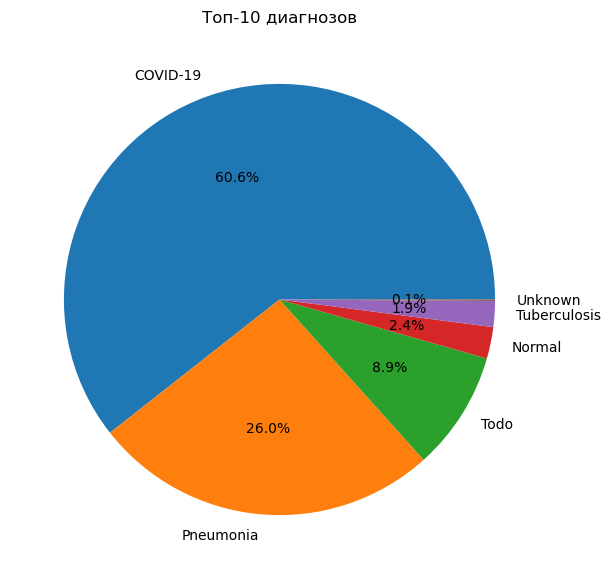

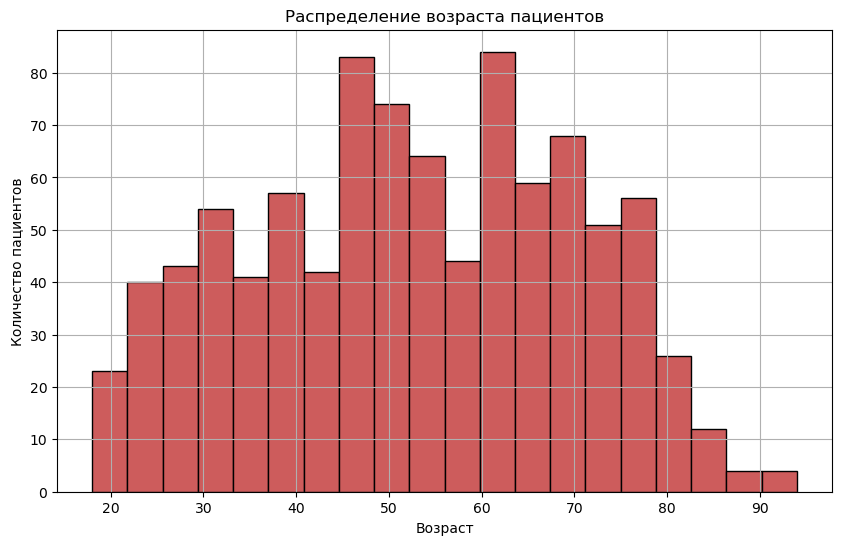


Spark сессия закрыта


In [140]:
import matplotlib.pyplot as plt

# 1. Круговая диаграмма диагнозов
diagnosis_counts = df.groupBy("finding").agg(count("*").alias("count")) \
                   .orderBy(col("count").desc()).limit(10).toPandas()

plt.figure(figsize=(10, 7))
plt.pie(diagnosis_counts['count'], labels=diagnosis_counts['finding'], autopct='%1.1f%%')
plt.title('Топ-10 диагнозов')
plt.show()

# 2. Гистограмма возраста
age_data = df.select("age").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(age_data['age'], bins=20, color='indianred', edgecolor='black')
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.grid(True)
plt.show()
spark.stop()
print("\nSpark сессия закрыта")